In [1]:
%matplotlib inline

import functools
import os
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
tqdm.pandas("Progress: ")

import numpy as np
import matplotlib
import pandas as pd
import pybedtools
import pysam
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import scipy
from gscripts import qtools
from Bio import SeqIO
from gscripts.general import dataviz
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from gscripts.encode import encode_helpers
img_dir = "/home/gpratt/Dropbox/EricGabe_ENCODE/papers/peaks_outside_genes"

sns.set_style("ticks")

RESET = False

In [2]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"

In [4]:
def get_gps_peak(fn):
    gps_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    fn = os.path.basename(fn)
    basename = fn.split(".")[0]
    
    fn = os.path.join(gps_dir, "{}/{}_outputs/{}_2_GEM_events.bed".format(basename, basename, basename))
    return fn

def get_idr_peak(row):
    gps_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    fn = "_".join(row.name) + ".idr.peaks_loose.bed"    
    fn = os.path.join(gps_dir, fn)
    return fn

def sort_and_return_peaks(fn, force=False):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    
    out_fn = os.path.basename(fn)
    out_fn = os.path.splitext(out_fn)[0] + ".sorted.bed"
    out_fn = os.path.join(out_dir, out_fn)
    if os.path.exists(out_fn) and not RESET:
        return out_fn
    
    bedtool = pybedtools.BedTool(fn)
    bedtool = pybedtools.BedTool([pybedtools.create_interval_from_list(str(interval).split()) for interval in bedtool])

    
    bedtool = bedtool.sort().saveas(out_fn)
    return bedtool.fn

def filter_idr_peak(fn):
    out_fn = os.path.splitext(fn)[0] + ".filtered.bed"
    
    if os.path.exists(out_fn) and not RESET:
        return out_fn
    bedtool = pybedtools.BedTool(fn)
    bedtool.filter(lambda interval: interval.score > 540).saveas(out_fn)
    return out_fn

In [5]:
make_and_filter_clipper_stringent = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=5, pval=3)
make_and_filter_clipper_very_lineant = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=0, pval=1)
make_and_filter_clipper_lineant = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=2, pval=1.3)
make_and_filter_clipper_moderate = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=3, pval=3)

In [6]:
merged_data = encode_helpers.get_merged_data()

#For Peak Analysis we only want to analyze datasets that have been submitted
merged_data = merged_data[merged_data.submitted]
merged_data = merged_data[['CLIP', 'INPUT', 'input_norm']]
merged_data['filtered_moderate'] = merged_data['input_norm'].progress_apply(make_and_filter_clipper_moderate)
merged_data['gps'] = merged_data.CLIP.progress_apply(get_gps_peak).progress_apply(sort_and_return_peaks)
submitted_datasets = merged_data
submitted_datasets = submitted_datasets.xs("rep1", level="rep").copy()

100%|██████████| 362/362 [00:00<00:00, 3995.81it/s]


In [7]:
submitted_datasets.gps = submitted_datasets.apply(get_idr_peak, axis=1).progress_apply(sort_and_return_peaks).progress_apply(filter_idr_peak)

100%|██████████| 181/181 [00:00<00:00, 4339.70it/s]


In [8]:
#For testing purposes
#submitted_datasets = submitted_datasets.head()

In [9]:
genes_v19 = pybedtools.BedTool("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf").sort().saveas()
genes_v25 = pybedtools.BedTool("/projects/ps-yeolab/genomes/hg19/gencode/v25/gencode.v25lift37.annotation.gtf").sort().saveas()
genes_v25 = genes_v25.filter(lambda x: not x.chrom.startswith("GL")).saveas()

In [10]:
# I look at v25 vs v19 to see if the lincRNA annotations mean much
def get_lengths(fn):
    result = !wc -l $fn
    result = result[0].split()[0]
    return int(result)

def intersect_v19(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_in_v19.bed")
    
    if os.path.exists(out_fn) and not RESET:
        return out_fn

    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v19, 
                                u=True, 
                                s=True, 
                                sorted=True
                               ).saveas(out_fn)
    return bedtool.fn

def not_in_v19(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_not_in_v19.bed")
    
    if os.path.exists(out_fn) and not RESET:  
        return out_fn

    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v19, 
                                v=True,
                                s=True,
                                sorted=True
                               ).saveas(out_fn)
    return bedtool.fn

def intersect_v25(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_in_v25.bed")

    if os.path.exists(out_fn) and not RESET:
        return out_fn

    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v25, u=True, s=True, sorted=True).saveas(out_fn)
    return bedtool.fn

def not_in_v25(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_not_in_v25.bed")

    if os.path.exists(out_fn) and not RESET:
        return out_fn

    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v25, v=True, s=True, sorted=True).saveas(out_fn)
    return bedtool.fn

In [12]:
submitted_datasets['v19_counts'] = submitted_datasets.gps.progress_apply(intersect_v19)
submitted_datasets['not_in_v19_counts'] = submitted_datasets.gps.progress_apply(not_in_v19)
submitted_datasets['v25_counts'] = submitted_datasets.gps.progress_apply(intersect_v25)
submitted_datasets['not_in_v25_counts'] = submitted_datasets.gps.progress_apply(not_in_v25)

100%|██████████| 181/181 [17:29<00:00,  4.51s/it]


In [13]:
submitted_datasets_lengths = submitted_datasets[['v19_counts', 
                                                 "not_in_v19_counts",
                                                 'v25_counts', 
                                                 'not_in_v25_counts', 
                                                 'gps']].applymap(get_lengths)

In [14]:
#submitted_datasets_lengths['fraction_outside_peaks'] = submitted_datasets_lengths.not_in_v25_counts / submitted_datasets_lengths.gps 
submitted_datasets_lengths['fraction_outside_peaks'] = submitted_datasets_lengths.not_in_v19_counts / submitted_datasets_lengths.gps 

submitted_datasets_lengths['fraction_in_v19'] = submitted_datasets_lengths.v19_counts / submitted_datasets_lengths.gps 
submitted_datasets_lengths['only_in_v25_genes'] = ((submitted_datasets_lengths.v25_counts - submitted_datasets_lengths.v19_counts) / submitted_datasets_lengths.gps) * 100 
submitted_datasets_lengths['only_in_v25_genes_fold'] = ((submitted_datasets_lengths.v25_counts - submitted_datasets_lengths.v19_counts) / submitted_datasets_lengths.v19_counts) * 100 

# Find or Make code that overlaps GPS/GEM with filtered clipper peaks
Found in 20161020_gps_gem_analysis, figure made if we need it, about ~60% overlaps


# How much does v25 improve annotation quality

In [15]:
sns.set_style("ticks")

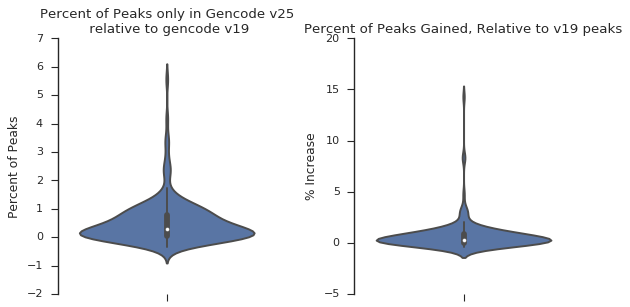

In [16]:
num_rows = 1 
num_cols = 2

results = {}
mean_results = {}
with dataviz.Figure(os.path.join(img_dir, "v25_v19_comparison.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    sns.violinplot(submitted_datasets_lengths['only_in_v25_genes'], orient="v", ax=ax)
    ax.set_title("Percent of Peaks only in Gencode v25\n relative to gencode v19")
    ax.set_ylabel("Percent of Peaks")
    sns.despine(ax=ax, trim=True)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    
    sns.violinplot(submitted_datasets_lengths['only_in_v25_genes_fold'], orient="v", ax=ax)
    ax.set_title("Percent of Peaks Gained, Relative to v19 peaks")
    ax.set_ylabel("% Increase")
    sns.despine(ax=ax, trim=True)

The conclusion here is that v25 at most increases peak detection by ~4%, not really worth discussing relative to everything else.  We only gain at most ~8% peaks, and frequently only ~2%.  I'm going to ignore v25 for the purposes of this study.

# How many peaks fall outside of genes

In [17]:
submitted_datasets_lengths_filtered = submitted_datasets_lengths[submitted_datasets_lengths.gps > 1000]
submitted_datasets_lengths_filtered = submitted_datasets_lengths_filtered.sort_values("fraction_outside_peaks", 
                                                                                      ascending=False)

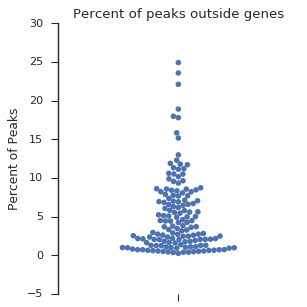

In [18]:
num_rows = 1 
num_cols = 1 

results = {}
mean_results = {}
with dataviz.Figure(os.path.join(img_dir, "peaks_outside_genes.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.swarmplot(submitted_datasets_lengths_filtered['fraction_outside_peaks'] * 100, orient="v", ax=ax)
    ax.set_title("Percent of peaks outside genes")
    ax.set_ylabel("Percent of Peaks")
    sns.despine(ax=ax, trim=True)

Most peaks fall within genes, but some interesting cases where it doesn't.  

Next Step is to create an iterative list to explain a large and larger fraction of these peaks

# Anti-sense Peaks

In [19]:
def antisense_peaks(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks/processed_peaks/"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_antisense.bed")
    
    if os.path.exists(out_fn) and not RESET:
        return out_fn
    
    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v19, u=True, S=True, sorted=True).saveas(out_fn)
    return bedtool.fn

def not_antisense_peaks(fn):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks/processed_peaks/"
    out_fn = os.path.join(out_dir, os.path.basename(fn).split(".")[0] + "_not_antisense.bed")
    
    if os.path.exists(out_fn) and not RESET:
        return out_fn
    
    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.intersect(genes_v19, v=True, S=True, sorted=True).saveas(out_fn)
    return bedtool.fn

In [20]:
submitted_datasets['antisense_peaks'] = submitted_datasets['not_in_v19_counts'].progress_apply(antisense_peaks)
submitted_datasets['not_antisense_peaks'] = submitted_datasets['not_in_v19_counts'].progress_apply(not_antisense_peaks)

100%|██████████| 181/181 [11:47<00:00,  3.89s/it]


In [21]:
submitted_datasets_lengths['antisense_counts'] = submitted_datasets['antisense_peaks'].progress_apply(get_lengths)
submitted_datasets_lengths['not_antisense_counts'] = submitted_datasets['not_antisense_peaks'].progress_apply(get_lengths)

submitted_datasets_lengths['antisense_peaks_fraction'] = submitted_datasets_lengths['antisense_counts']  / submitted_datasets_lengths.not_in_v19_counts

100%|██████████| 181/181 [00:02<00:00, 86.44it/s]


In [22]:
submitted_datasets_lengths_filtered = submitted_datasets_lengths[submitted_datasets_lengths.gps > 1000]

In [23]:
submitted_datasets_lengths_filtered.sort_values("antisense_counts", ascending=False)[['antisense_counts', 'antisense_peaks_fraction']]

,,CLIP,antisense_counts,antisense_peaks_fraction
uID,Cell line,RBP,,
292,HepG2,CSTF2T,615,0.306428
678,HepG2,HNRNPL,413,0.180192
297,HepG2,FAM120A,390,0.314263
206,HepG2,HNRNPK,365,0.297231
560,K562,HNRNPL,344,0.120028
267,K562,SAFB2,286,0.167056
572,HepG2,CSTF2,273,0.165354
478,HepG2,QKI,256,0.181947
439,K562,KHSRP,245,0.073884


In [24]:
# num_rows = 1 
# num_cols = 2 

# results = {}
# mean_results = {}
# with dataviz.Figure(os.path.join(img_dir, "antisense_peaks.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
#     ax = fig.add_subplot(num_rows, num_cols, 1)

#     ax.scatter(submitted_datasets_lengths_filtered.antisense_counts, submitted_datasets_lengths_filtered.downstream_flanking_counts)
#     ax.set_xlabel("anti-sense peaks")
#     ax.set_ylabel("peaks downstream of known genes")
#     sns.despine(ax=ax)
#     ax.set_xlim(0,)
#     ax.set_ylim(0,)

#     ax = fig.add_subplot(num_rows, num_cols, 2)

#     ax.scatter(submitted_datasets_lengths_filtered.antisense_peaks_fraction, submitted_datasets_lengths_filtered.downstream_flanking_fraction)
#     ax.set_xlabel("fraction anti-sense peaks")
#     ax.set_ylabel("fraction peaks downstream of known genes")
#     sns.despine(ax=ax)

In [25]:
# num_rows = 1 
# num_cols = 1 

# results = {}
# mean_results = {}
# with dataviz.Figure(os.path.join(img_dir, "antisense_peaks.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
#     ax = fig.add_subplot(1,1,1)
    
#     sns.swarmplot(submitted_datasets_lengths_filtered['antisense_peaks_fraction'] * 100, orient="v", ax=ax)
#     ax.set_title("Percent of anti-sense peaks")
#     ax.set_ylabel("Percent of Peaks")
#     sns.despine(ax=ax)
#     ax.set_ylim(0,40)

A pretty large number of peaks not in tradtional genes are anti-sense.  This might be worth following up on   

# How many peaks flank genes
Do this two ways, look at distribution then draw cutoff to plot / count

In [26]:
# header = ['chrom_peak', 'start_peak', 'stop_peak', 'name_peak', 'score_peak', 'strand_peak',
# 'chrom_gene', 'source_gene', 'annotation_gene', 'start_gene', "stop_gene", "score_gene", "strand_gene", "name_gene", "other_gene", "dist"]

#For IDR

idr_header = ['chrom_peak', 'start_peak', 'stop_peak', 'name_peak', 'score_peak', 'strand_peak', 'signalValue_peak', 'p_value_peak', 'q_value_peak', 'summit_peak', 'localIDR_peak', 'globalIDR_peak', 'rep1_chromStart',  'rep1_chromEnd',]
gff_header = ['chrom_gene', 'source_gene', 'annotation_gene', 'start_gene', "stop_gene", "score_gene", "strand_gene", "name_gene", "other_gene"] 
header = idr_header + gff_header + ["dist"]


In [27]:
#should figure out why bedtools closest is returning nans sometimes..., I'm losing more than a few peaks
def get_dist_from_gene(fn):

    bedtool = pybedtools.BedTool(fn)
    df = bedtool.closest(genes_v19, D="b", s=True).to_dataframe(names=header)

    max_value = 100000
    df.loc[df.dist > max_value, "dist"] = max_value
    df.loc[df.dist < -1 * max_value, "dist"] = -1 * max_value
    df = df.groupby(["chrom_peak","start_peak","stop_peak","name_peak","score_peak","strand_peak"]).first()
    df = df.reset_index(["chrom_peak","start_peak","stop_peak","name_peak","score_peak","strand_peak"])

    return df

distances = submitted_datasets.not_antisense_peaks.progress_apply(get_dist_from_gene)

100%|██████████| 181/181 [15:25<00:00,  5.29s/it]


100%|██████████| 181/181 [00:18<00:00, 14.48it/s]


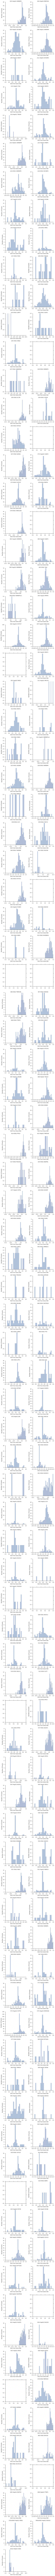

In [28]:
num_cols = 2 
num_rows = (len(distances) / num_cols) + 1  

xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000, ','))
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    for x, (name, df) in  enumerate(tqdm(list(distances.iteritems()))):
        ax = fig.add_subplot(num_rows,num_cols,x + 1)
        if len(df) > 10:
            
            sns.distplot(df.dist.dropna(), ax=ax, kde=False, hist=True, bins=range(-5000, 5000 + 500, 500))
            sns.despine(ax=ax)
            ax.set_xlabel("Dist From Gene (Kb)")
            ax.set_ylabel("Number of Events")
            ax.set_title(" ".join(name))
            ax.xaxis.set_major_formatter(xfmt)


In [29]:
def output_name(name):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks/processed_peaks/"
    if len(name) == 3:
        rep_num = ""
    elif name[3] == "rep1":
        rep_num = "01"
    elif name[3] == "rep2":
        rep_num = "02"
    
    upstream = "_2_GEM_events_not_in_v19_upstream.bed"
    downstream = "_2_GEM_events_not_in_v19_downstream.bed"
    out_tail = "_2_GEM_events_not_in_v19_not_close.bed"

    out_base_order = "_".join([name[0], rep_num, name[2]])
    return os.path.join(out_dir, out_base_order + upstream), os.path.join(out_dir, out_base_order + downstream), os.path.join(out_dir, out_base_order + out_tail)

In [30]:
upstream_result = []
downstream_result = []
excluded_result = []

max_dist = 5000
for x, (name, df) in  enumerate(tqdm(list(distances.iteritems()))):
        
    upstream, downstream, excluded = output_name(name)
    kept_df = df[np.abs(df.dist) <= max_dist]
    
    upstream_df = kept_df[kept_df.dist < 0]
    downstream_df = kept_df[kept_df.dist > 0]
    upstream_df = upstream_df[idr_header]
    downstream_df = downstream_df[idr_header]
    
    excluded_df = df[np.abs(df.dist) > max_dist]
    excluded_df = excluded_df[idr_header]
    
    upstream_result.append(upstream)
    downstream_result.append(downstream)
    excluded_result.append(excluded)
                                          
    upstream_df.to_csv(upstream, sep="\t", index=False, index_label=False, header=False)
    downstream_df.to_csv(downstream, sep="\t", index=False, index_label=False, header=False)
    excluded_df.to_csv(excluded, sep="\t", index=False, index_label=False, header=False)
submitted_datasets['upstream_flanking'] = upstream_result
submitted_datasets['downstream_flanking'] = downstream_result

submitted_datasets['not_flanking'] = excluded_result

100%|██████████| 181/181 [00:08<00:00, 20.47it/s]


In [31]:
submitted_datasets_lengths['upstream_flanking_counts'] = submitted_datasets.upstream_flanking.progress_apply(get_lengths)
submitted_datasets_lengths['downstream_flanking_counts'] = submitted_datasets.downstream_flanking.progress_apply(get_lengths)
submitted_datasets_lengths['not_flanking_counts'] = submitted_datasets.not_flanking.progress_apply(get_lengths)

100%|██████████| 181/181 [00:04<00:00, 45.95it/s]


# Try Antisense flanking now, how much does that get?

In [32]:
def get_dist_from_gene_antisense(fn):

    bedtool = pybedtools.BedTool(fn)
    df = bedtool.closest(genes_v19, D="b", S=True).to_dataframe(names=header)

    max_value = 100000
    df.loc[df.dist > max_value, "dist"] = max_value
    df.loc[df.dist < -1 * max_value, "dist"] = -1 * max_value

    df = df.groupby(["chrom_peak","start_peak","stop_peak","name_peak","score_peak","strand_peak"]).first()
    df = df.reset_index(["chrom_peak","start_peak","stop_peak","name_peak","score_peak","strand_peak"])
    
    return df

distances_antisense = submitted_datasets.not_flanking.progress_apply(get_dist_from_gene_antisense)

100%|██████████| 181/181 [15:00<00:00,  5.03s/it]


In [33]:
def output_name_antisense(name):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks/processed_peaks/"
    if len(name) == 3:
        rep_num = ""
    elif name[3] == "rep1":
        rep_num = "01"
    elif name[3] == "rep2":
        rep_num = "02"
        
    upstream = "_2_GEM_events_not_in_v19_upstream_antisense.bed"
    downstream = "_2_GEM_events_not_in_v19_downstream_antisense.bed"

    out_tail = "_2_GEM_events_not_in_v19_not_close_antisense.bed"

    out_base_order = "_".join([name[0], rep_num, name[2]])
    return os.path.join(out_dir, out_base_order + upstream), os.path.join(out_dir, out_base_order + downstream), os.path.join(out_dir, out_base_order + out_tail)

In [34]:
upstream_result = []
downstream_result = []
excluded_result = []

for x, (name, df) in  enumerate(tqdm(list(distances_antisense.iteritems()))):

    upstream, downstream, excluded = output_name_antisense(name)
    kept_df = df[np.abs(df.dist) <= max_dist]
    
    upstream_df = kept_df[kept_df.dist < 0]
    downstream_df = kept_df[kept_df.dist > 0]
    upstream_df = upstream_df[idr_header]
    downstream_df = downstream_df[idr_header]
    
    excluded_df = df[np.abs(df.dist) > max_dist]
    excluded_df = excluded_df[idr_header]
    
    upstream_result.append(upstream)
    downstream_result.append(downstream)
    excluded_result.append(excluded)
                                          
    upstream_df.to_csv(upstream, sep="\t", index=False, index_label=False, header=False)
    downstream_df.to_csv(downstream, sep="\t", index=False, index_label=False, header=False)
    excluded_df.to_csv(excluded, sep="\t", index=False, index_label=False, header=False)

submitted_datasets['upstream_flanking_antisense'] = upstream_result
submitted_datasets['downstream_flanking_antisense'] = downstream_result
submitted_datasets['not_flanking_antisense'] = excluded_result

100%|██████████| 181/181 [00:10<00:00, 16.97it/s]


In [35]:
submitted_datasets_lengths['upstream_flanking_antisense_counts'] = submitted_datasets.upstream_flanking_antisense.progress_apply(get_lengths)
submitted_datasets_lengths['downstream_flanking_antisense_counts'] = submitted_datasets.downstream_flanking_antisense.progress_apply(get_lengths)
submitted_datasets_lengths['not_flanking_antisense_counts'] = submitted_datasets.not_flanking_antisense.progress_apply(get_lengths)

100%|██████████| 181/181 [00:04<00:00, 40.21it/s]


In [36]:
submitted_datasets_lengths['upstream_flanking_fraction'] = submitted_datasets_lengths.upstream_flanking_counts / submitted_datasets_lengths.not_in_v19_counts
submitted_datasets_lengths['downstream_flanking_fraction'] = submitted_datasets_lengths.downstream_flanking_counts / submitted_datasets_lengths.not_in_v19_counts

submitted_datasets_lengths['upstream_flanking_antisense_fraction'] = submitted_datasets_lengths.upstream_flanking_antisense_counts / submitted_datasets_lengths.not_in_v19_counts
submitted_datasets_lengths['downstream_flanking_antisense_fraction'] = submitted_datasets_lengths.downstream_flanking_antisense_counts / submitted_datasets_lengths.not_in_v19_counts

# DNAse Hypersenesitive Sites

In [37]:
# #K562
# !wget https://www.encodeproject.org/files/ENCFF001WNM/@@download/ENCFF001WNM.bed.gz
    
# #HepG2
# !wget https://www.encodeproject.org/files/ENCFF942AZB/@@download/ENCFF942AZB.bed.gz

In [38]:
k562_dnase = pybedtools.BedTool("ENCFF001WNM.bed.gz")
hepg2_dnase = pybedtools.BedTool("ENCFF942AZB.bed.gz")

In [39]:
submitted_datasets['antisense_peaks'] = submitted_datasets['not_in_v19_counts'].progress_apply(antisense_peaks)
submitted_datasets['not_antisense_peaks'] = submitted_datasets['not_in_v19_counts'].progress_apply(not_antisense_peaks)

100%|██████████| 181/181 [12:46<00:00,  3.98s/it]


In [40]:
kept_peaks = []
excluded_peaks = []
for name, row in tqdm(list(submitted_datasets.iterrows())):
    if len(name) == 3:
        uid, cell_type, rbp = name
        rep = ""
    elif len(name) == 4:
        uid, cell_type, rbp, rep = name
    else:
        print "len wrong", len(name)
        
    if cell_type == "HepG2":
        dnase = hepg2_dnase
    elif cell_type == "K562":
        dnase = k562_dnase
    
    if rep == "":
        rep_num = ""
    elif rep == "rep1":
        rep_num = "01"
    elif rep == "rep2":
        rep_num = "02"

    out_base_order = "_".join([uid, rep_num, cell_type])
    in_tail = "_2_GEM_events_not_in_v19_dnase.bed"
    out_tail = "_2_GEM_events_not_in_v19_not_dnase.bed"

    in_fn = os.path.join(out_dir, out_base_order + in_tail)
    out_fn = os.path.join(out_dir, out_base_order + out_tail)

    peaks = pybedtools.BedTool(row.not_flanking_antisense)
    kept_peaks.append(peaks.intersect(dnase, u=True, sorted=True).saveas(in_fn).fn)
    excluded_peaks.append(peaks.intersect(dnase, v=True, sorted=True).saveas(out_fn).fn)

submitted_datasets['dnase'] = kept_peaks
submitted_datasets['not_dnase'] = excluded_peaks

100%|██████████| 181/181 [02:21<00:00,  1.33it/s]


In [41]:
submitted_datasets_lengths['dnase_counts'] = submitted_datasets.dnase.progress_apply(get_lengths)
submitted_datasets_lengths['not_dnase_counts'] = submitted_datasets.not_dnase.progress_apply(get_lengths)

submitted_datasets_lengths['dnase_fraction'] = submitted_datasets_lengths.dnase_counts / submitted_datasets_lengths.not_in_v19_counts
submitted_datasets_lengths['not_dnase_fraction'] = submitted_datasets_lengths.not_dnase_counts / submitted_datasets_lengths.not_in_v19_counts

100%|██████████| 181/181 [00:04<00:00, 39.31it/s]


# Plot Results

In [42]:
submitted_datasets_lengths['col_names'] = ["_".join(item) for item in submitted_datasets_lengths.index]

plotting_order_fraction = ['upstream_flanking_fraction',
'downstream_flanking_fraction',
'upstream_flanking_antisense_fraction',
'downstream_flanking_antisense_fraction',
'dnase_fraction',]

plotting_order_counts = ['upstream_flanking_counts',
'downstream_flanking_counts',
'upstream_flanking_antisense_counts',
'downstream_flanking_antisense_counts',
'dnase_counts',]


In [43]:
for col in range(len(plotting_order_fraction)):
    cumsum_label = plotting_order_fraction[col] + "_cumsum"
    submitted_datasets_lengths[cumsum_label] = submitted_datasets_lengths[plotting_order_fraction[:col + 1]].sum(axis=1)
    
for col in range(len(plotting_order_counts)):
    cumsum_label = plotting_order_counts[col] + "_cumsum"
    submitted_datasets_lengths[cumsum_label] = submitted_datasets_lengths[plotting_order_counts[:col + 1]].sum(axis=1)

In [44]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_fraction[0],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

In [45]:
colors = sns.color_palette("Set2", 6)

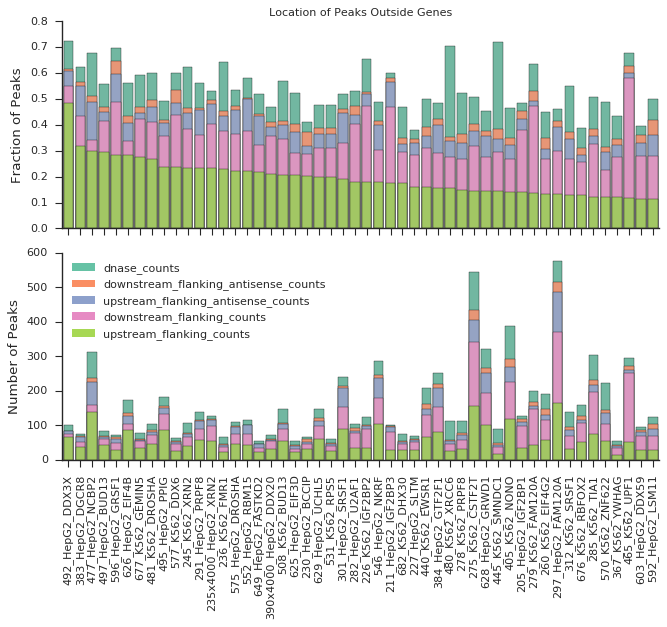

In [46]:
num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

In [47]:
plotting_order_fraction

['upstream_flanking_fraction',
 'downstream_flanking_fraction',
 'upstream_flanking_antisense_fraction',
 'downstream_flanking_antisense_fraction',
 'dnase_fraction']

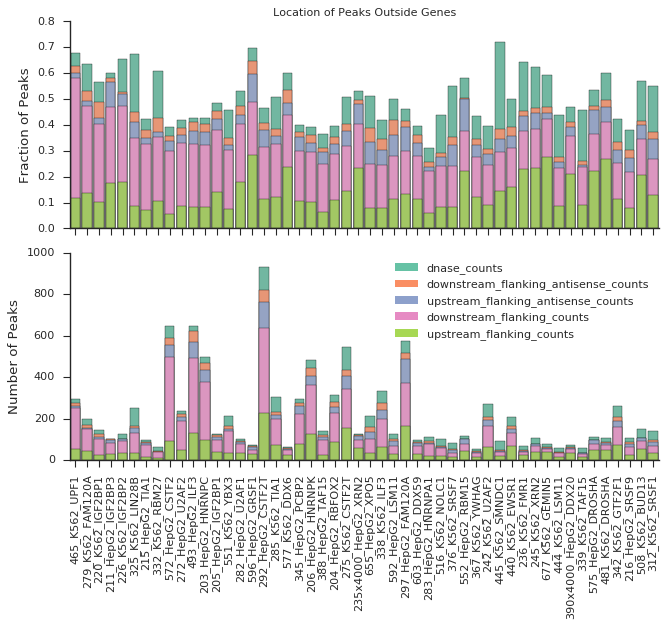

In [48]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_fraction[1],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

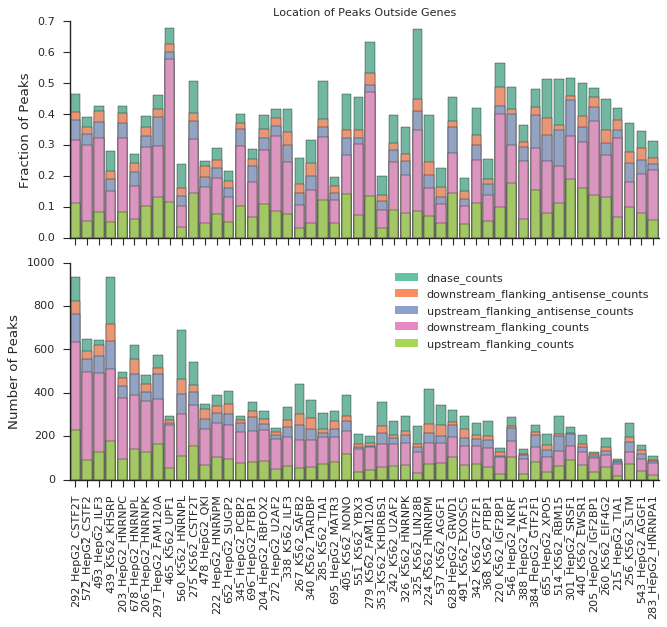

In [49]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_counts[1],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

100%|██████████| 10/10 [00:00<00:00, 13.23it/s]


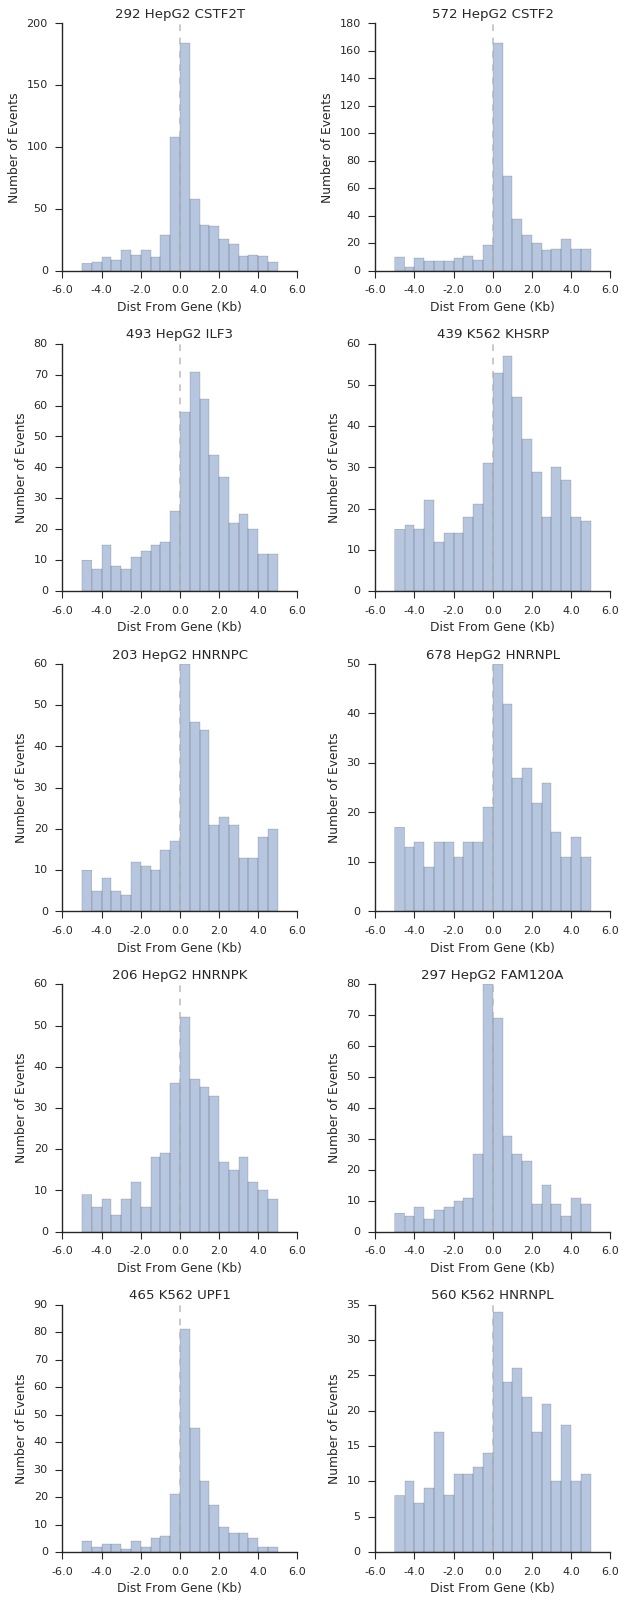

In [50]:
interesting_rbps = distances[submitted_datasets_lengths_sorted.iloc[:10].index]

num_cols = 2 
num_rows = (len(distances) / num_cols) + 1  

xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000, ','))
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    for x, (name, df) in  enumerate(tqdm(list(interesting_rbps.iteritems()))):
        ax = fig.add_subplot(num_rows,num_cols,x + 1)
        if len(df) > 10:
            dist = df.dist
            dist = dist[dist > -5000]
            dist = dist[dist < 5000]
            sns.distplot(dist.dropna(), ax=ax, kde=False, hist=True, bins=range(-5000, 5000 + 500, 500))
            sns.despine(ax=ax)
            ax.set_xlabel("Dist From Gene (Kb)")
            ax.set_ylabel("Number of Events")
            ax.set_title(" ".join(name))
            ax.xaxis.set_major_formatter(xfmt)
            ax.axvline(0, linestyle="--", color=".7", alpha=.7)
#HTML(distances.xs("ILF3", level="RBP")[0].head().to_html())

In [51]:
len(distances.xs("ILF3", level="RBP")[1])

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1730: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self.ix[indexer]
/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:780: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_lowerdim(tup)


1280

In [52]:
HTML(distances.xs("ILF3", level="RBP")[0].head(n=30).to_html())

,chrom_peak,start_peak,stop_peak,name_peak,score_peak,strand_peak,signalValue_peak,p_value_peak,q_value_peak,summit_peak,localIDR_peak,globalIDR_peak,rep1_chromStart,rep1_chromEnd,chrom_gene,source_gene,annotation_gene,start_gene,stop_gene,score_gene,strand_gene,name_gene,other_gene,dist
0,chr1,676177,676378,.,603,-,0.77,1.45,676177,676377,9.4,676178,676378,4.0,chr1,HAVANA,gene,677193,685396,.,-,.,"gene_id ""ENSG00000235373.1""; transcript_id ""EN...",815
1,chr1,1187427,1187634,.,1000,-,2.46,2.85,1187427,1187627,43.9,1187434,1187634,35.9,chr1,HAVANA,exon,1185157,1186714,.,-,.,"gene_id ""ENSG00000260179.1""; transcript_id ""EN...",-714
2,chr1,1188650,1188901,.,1000,-,2.20,2.60,1188678,1188878,39.0,1188650,1188901,18.7,chr1,HAVANA,gene,1189289,1209265,.,-,.,"gene_id ""ENSG00000160087.16""; transcript_id ""E...",388
3,chr1,1343159,1343482,.,180,+,-0.00,0.43,1343282,1343482,6.5,1343159,1343359,3.2,chr1,HAVANA,exon,1344476,1345998,.,+,.,"gene_id ""ENSG00000272455.1""; transcript_id ""EN...",-994
4,chr1,16147190,16147391,.,894,-,1.76,2.15,16147190,16147390,16.3,16147191,16147391,25.0,chr1,ENSEMBL,exon,16133679,16134194,.,-,.,"gene_id ""ENSG00000233954.4""; transcript_id ""EN...",-12997
5,chr1,23619320,23619548,.,573,-,0.43,1.38,23619320,23619520,5.1,23619348,23619548,8.0,chr1,HAVANA,gene,23607802,23613245,.,-,.,"gene_id ""ENSG00000261326.2""; transcript_id ""EN...",-6076
6,chr1,23619789,23619990,.,574,-,0.44,1.38,23619789,23619989,5.6,23619790,23619990,9.3,chr1,HAVANA,gene,23607802,23613245,.,-,.,"gene_id ""ENSG00000261326.2""; transcript_id ""EN...",-6545
7,chr1,23620798,23621001,.,659,-,1.19,1.59,23620801,23621001,6.5,23620798,23620998,6.3,chr1,HAVANA,gene,23607802,23613245,.,-,.,"gene_id ""ENSG00000261326.2""; transcript_id ""EN...",-7554
8,chr1,23621360,23621898,.,180,-,-0.00,0.43,23621536,23621736,3.5,23621360,23621898,4.0,chr1,HAVANA,gene,23607802,23613245,.,-,.,"gene_id ""ENSG00000261326.2""; transcript_id ""EN...",-8116
9,chr1,23627466,23627669,.,578,-,0.48,1.39,23627469,23627669,5.0,23627466,23627666,7.5,chr1,HAVANA,gene,23630264,23670829,.,-,.,"gene_id ""ENSG00000125944.14""; transcript_id ""E...",2595


In [53]:
# 572, 292, 439, 678, 439

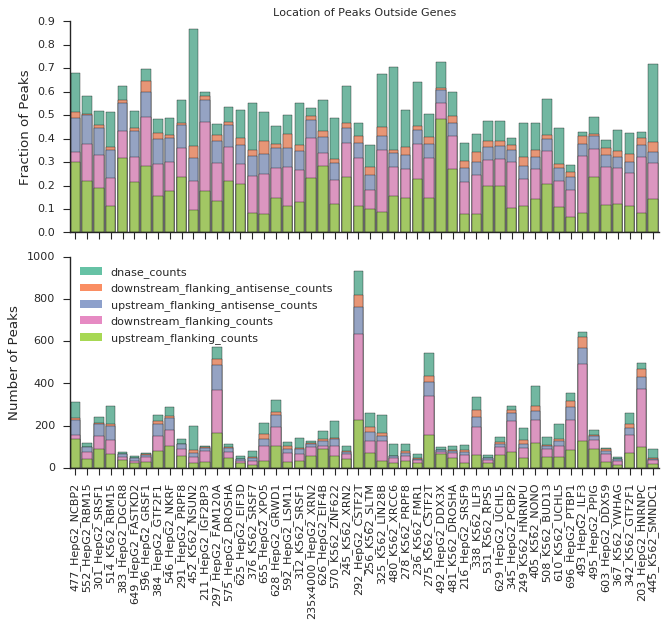

In [54]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_fraction[2],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

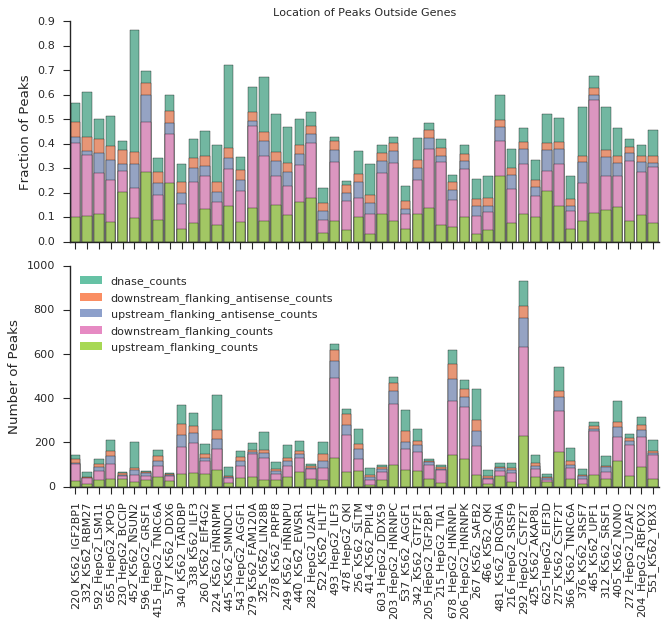

In [55]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_fraction[3],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

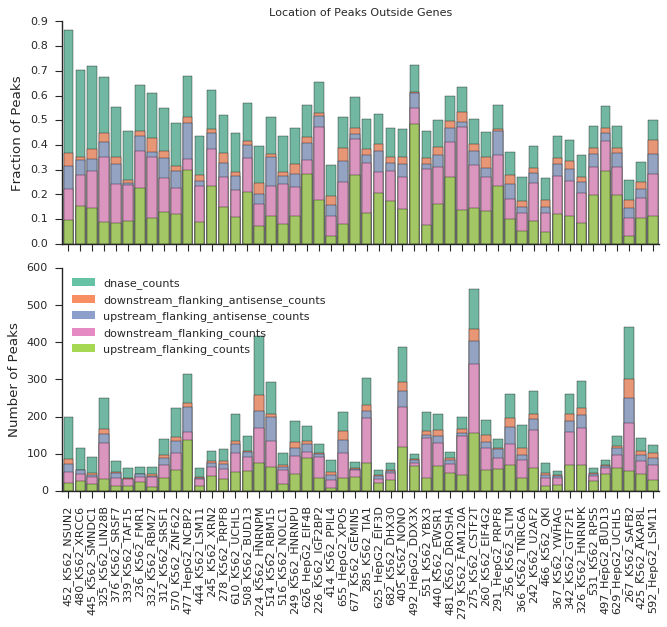

In [56]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_fraction[4],
                                                                          ascending=False)
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    for x, col in enumerate(reversed(plotting_order_fraction)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts)):
        col = col + "_cumsum"
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts), 
                  loc=0, prop={'size':10})

# Fraction of total peaks outside of Genes

In [57]:
submitted_datasets_lengths['col_names'] = ["_".join(item) for item in submitted_datasets_lengths.index]

plotting_order_counts_total = ['v19_counts',
                               'upstream_flanking_counts',
                               'downstream_flanking_counts',
                               'upstream_flanking_antisense_counts',
                               'downstream_flanking_antisense_counts',
                               'dnase_counts',
]

plotting_order_counts_total_fraction = [item + "_total_fraction" for item in plotting_order_counts_total]
plotting_order_counts_total_fraction_cumsum = [item + "_cumsum" for item in plotting_order_counts_total_fraction]

plotting_order_counts_total_counts_cumsum = [item + "_total_counts_cumsum" for item in plotting_order_counts_total]

for col, out_col in zip(plotting_order_counts_total, plotting_order_counts_total_fraction):
    submitted_datasets_lengths[out_col] = submitted_datasets_lengths[col] / submitted_datasets_lengths['gps']

for col, out_col in zip(range(len(plotting_order_counts_total_fraction)), plotting_order_counts_total_fraction_cumsum):
    submitted_datasets_lengths[out_col] = submitted_datasets_lengths[plotting_order_counts_total_fraction[:col + 1]].sum(axis=1)
    
for col, out_col in zip(range(len(plotting_order_counts_total)), plotting_order_counts_total_counts_cumsum):
    submitted_datasets_lengths[out_col] = submitted_datasets_lengths[plotting_order_counts_total[:col + 1]].sum(axis=1)

In [58]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values('dnase_counts_total_fraction_cumsum')
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

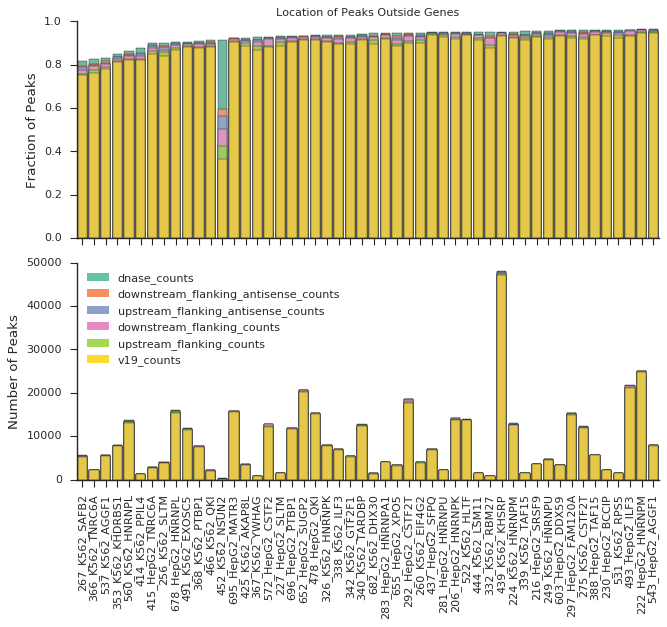

In [59]:
num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies_all.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)

    for x, col in enumerate(reversed(plotting_order_counts_total_fraction_cumsum)):
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts_total_counts_cumsum)):
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)    
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts_total)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts_total), 
                  loc=0, prop={'size':10})

In [60]:
submitted_datasets_lengths_sorted = submitted_datasets_lengths.sort_values(plotting_order_counts_total,
                                                                          ascending=[True, False, False, False, False, False])
submitted_datasets_lengths_sorted = submitted_datasets_lengths_sorted[submitted_datasets_lengths_sorted.not_in_v19_counts > 100]

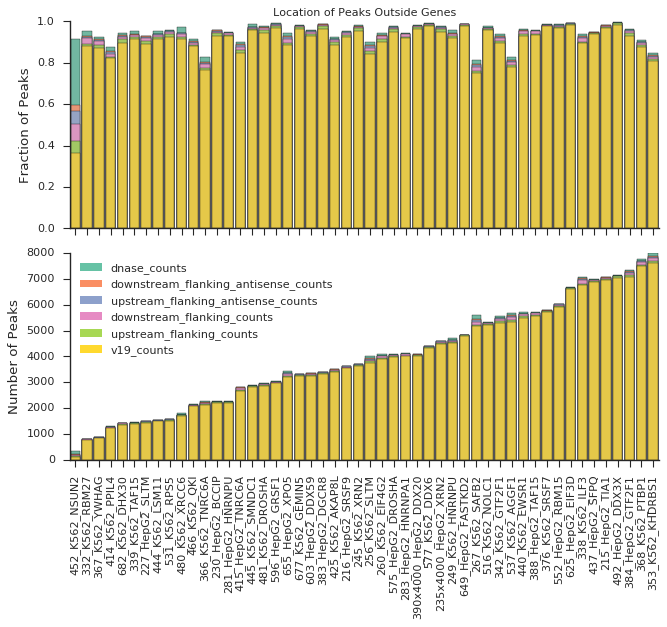

In [61]:
num_rows = 2
num_cols = 1
head_size = 50
with dataviz.Figure(os.path.join(img_dir, "peak_frequencies_all.svg"), figsize=(8.5 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)

    for x, col in enumerate(reversed(plotting_order_counts_total_fraction_cumsum)):
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)
        
    ax.set_xticklabels([])
    sns.despine(ax=ax)
    ax.set_ylabel("Fraction of Peaks", fontsize=12)
    ax.set_title("Location of Peaks Outside Genes", fontsize=10)
    ax.set_xlabel("")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for x, col in enumerate(reversed(plotting_order_counts_total_counts_cumsum)):
        sns.barplot(x='col_names', y=col, data=submitted_datasets_lengths_sorted.head(head_size),
                   color=colors[x], ax=ax)    
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Peaks", fontsize=12)
    ax.set_xlabel("")
    
    boxes = [plt.Rectangle((0,0),1,1, fc=colors[x], edgecolor = 'none') for x, name in enumerate(plotting_order_counts_total)]
    l = ax.legend(boxes, 
                  reversed(plotting_order_counts_total), 
                  loc=0, prop={'size':10})

Neither of these plots are super informative without some sort of hypothesis / followup.  Flanking is easier to explain than antisense.  Don't really know how to describe antisense binding

# Output For Eric / Anyone else to look at

In [62]:
submitted_datasets_lengths[['gps', 
                            'v19_counts', 'not_in_v19_counts', 
                            'antisense_counts', u'not_antisense_counts',
                            'flanking_counts', 'not_flanking_counts',
                            'flanking_antisense_counts', 'not_flanking_antisense_counts',
                            ]].to_csv(os.path.join(img_dir, "peak_locations.csv"))

KeyError: "['flanking_counts' 'flanking_antisense_counts'] not in index"

In [ ]:
os.path.join(img_dir, "peak_locations.csv")

# Random SPP Code I feel obligated to keep around

In [ ]:
all_exps = {}
for experiment in glob.glob("/home/gpratt/projects/encode/analysis/ad-hoc/spp/*broadPeak"):
    bedtool = pybedtools.BedTool(experiment)
    all_exps[os.path.basename(experiment).split(".")[0]] = bedtool.intersect(genes, v=True).saveas()
sns.distplot([len(x) for x in all_exps])